# <center><font size='20'> Predicting Apple stock price direction <br>with machine learning techniques </font></center>

# <center> I. Data Preparation </center>


# I.I. Data and packages loading:
-------------------------

In [1]:
# Import some required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.dates import DateFormatter
import seaborn as sb
import time

In [2]:
# Import AAPL.csv excel file into Pandas
apple = pd.read_csv('AAPL.csv')

In [3]:
# Check the size of the dataframe:
apple.shape

(5031, 7)

The dataframe contains 5031 rows and 7 columns.

In [4]:
# Set the Date column as datetime
apple['Date']=pd.to_datetime(apple['Date'])

In [5]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-07-11,0.375536,0.402679,0.375000,0.402500,0.346111,470506400
1,2001-07-12,0.416071,0.443036,0.416071,0.435000,0.374058,614801600
2,2001-07-13,0.430893,0.446607,0.425714,0.443750,0.381582,454742400
3,2001-07-16,0.444286,0.448214,0.426964,0.427857,0.367915,278667200
4,2001-07-17,0.428214,0.450357,0.410893,0.448214,0.385420,647830400


In [6]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5031 non-null   datetime64[ns]
 1   Open       5031 non-null   float64       
 2   High       5031 non-null   float64       
 3   Low        5031 non-null   float64       
 4   Close      5031 non-null   float64       
 5   Adj Close  5031 non-null   float64       
 6   Volume     5031 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 275.3 KB


In [7]:
# Filter dataset 
apple = apple[['Date', 'Adj Close', 'Volume']]

In [8]:
apple.set_index('Date', inplace=True)

In [9]:
apple.head()

,Adj Close,Volume
Date,,
2001-07-11,0.346111,470506400
2001-07-12,0.374058,614801600
2001-07-13,0.381582,454742400
2001-07-16,0.367915,278667200
2001-07-17,0.385420,647830400


In [10]:
apple.tail()

,Adj Close,Volume
Date,,
2021-07-02,139.960007,78852600
2021-07-06,142.020004,108181800
2021-07-07,144.570007,104911600
2021-07-08,143.240005,105575500
2021-07-09,145.110001,99788400


In [11]:
# Check null values
apple.isna().sum()

Adj Close    0
Volume       0
dtype: int64

# I.II. Create independent variables(x):
-------------------------

In the next step we need to set our desired predictor variables we are going to use to predict the target variable. These will be:
- `Adj Close`
- 20, 50 and 200 days Exponential Moving Average (EMA)
- 20, 50 and 200 days Relative Strength Index (RSI)
- 20 days Bollinger Bands
- MACD indicator with 12- and 26 days EMA and 9 days EMA as the signal line
- Last 7, 30, 90, days average trading volume change
- Last 7 and 30 days price change
- Daily log returns, weekly, monthly and yearly volatility


Since we have only the Adj Close and Volume columns at this point, we need to build the other columns. To calculate the indicators (RSI and EMA), we are going to use the Talib built in package.

> ### 1. Calculate EMA and RSI:

In [12]:
# Import Talib package
import talib as ta

feature_names = []
# Create moving averages and rsi for timeperiods of 20, 50, and 200
for n in [20, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    apple['ema' + str(n)] = ta.EMA(apple['Adj Close'].values,
                              timeperiod=n) 
    # Create the RSI indicator
    apple['rsi' + str(n)] = ta.RSI(apple['Adj Close'].values, timeperiod=n)
    
    # Add EMA, RSI to the feature name list
    feature_names = feature_names + ['ema' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200']


> ### 2. Calculate Bollinger Bands

In [13]:
# Create 20 days standard deviation
apple['20d_std'] = apple['Adj Close'].rolling(window=20).std()

# Create Bollinger bands:
apple['upper_bollinger'] = apple['ema20'] + (apple['20d_std'] * 2)
apple['lower_bollinger'] = apple['ema20'] - (apple['20d_std'] * 2)

# Add them to feature_names:
bollingers = ['upper_bollinger', 'lower_bollinger', '20d_std']
feature_names.extend(bollingers)

print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std']


> ### 3. Calculate MACD

In [14]:
# Calculate the 12-days and 26-days EMA for the MACD:
exp1 = apple['Adj Close'].ewm(span=12, adjust=False).mean()
exp2 = apple['Adj Close'].ewm(span=26, adjust=False).mean()

# MACD is simply the difference of the two EMA
macd = exp1-exp2

# Calculate the signal line:
exp3 = macd.ewm(span=9, adjust=False).mean()


apple['MACD'] = macd
apple['MACD_9EMA_signal'] = exp3

# Add them to feature_names:
MACD_lines = ['MACD','MACD_9EMA_signal']
feature_names.extend(MACD_lines)

print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std', 'MACD', 'MACD_9EMA_signal']


> ### 4. Average volume changes

In [15]:
# Calculate the rolling last 7 days, 30 days and 90 days average volume change:
apple['Volume 7d change'] = (apple['Volume'].pct_change()).rolling(7).mean()
apple['Volume 30d change'] = (apple['Volume'].pct_change()).rolling(30).mean()
apple['Volume 90d change'] = (apple['Volume'].pct_change()).rolling(90).mean()

# Add the columns to the feature_names:
volume_feature = ['Volume 7d change','Volume 30d change', 'Volume 90d change' ]
feature_names.extend(volume_feature)

print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std', 'MACD', 'MACD_9EMA_signal', 'Volume 7d change', 'Volume 30d change', 'Volume 90d change']


> ### 5. Last n days price change

In [16]:
# Calculate the 7 days and 30 days prior percentage change of the closing price:
apple['7d_price_change'] = apple['Adj Close'].pct_change(7)
apple['30d_price_change'] = apple['Adj Close'].pct_change(30)


# Add the columns to the feature_names:
price_changes = ['7d_price_change','30d_price_change']
feature_names.extend(price_changes)

print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std', 'MACD', 'MACD_9EMA_signal', 'Volume 7d change', 'Volume 30d change', 'Volume 90d change', '7d_price_change', '30d_price_change']


> ### 6. Calculate volatility

In [17]:
# First create Daily log returns (%) new column based on closing prices
apple['Daily log returns(%)'] = (np.log(apple['Adj Close'].pct_change()+1))*100

# Based on daily log returns let's create weekly, monthly and yearly volatility:
log_returns = apple['Daily log returns(%)']
apple['7d_volatility'] = log_returns.rolling(window=7).std()*np.sqrt(7)
apple['30d_volatility'] = log_returns.rolling(window=30).std()*np.sqrt(30)
apple['252d_volatility'] = log_returns.rolling(window=252).std()*np.sqrt(252)


# Add the columns to the feature_names:
volatilities = ['7d_volatility','30d_volatility','252d_volatility']
feature_names.extend(volatilities)

print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std', 'MACD', 'MACD_9EMA_signal', 'Volume 7d change', 'Volume 30d change', 'Volume 90d change', '7d_price_change', '30d_price_change', '7d_volatility', '30d_volatility', '252d_volatility']


After creating all the feature variables we need, check the head of the dataframe:

In [18]:
# Check the dataframe:
apple.head()

,Adj Close,Volume,ema20,rsi20,ema50,rsi50,ema200,rsi200,20d_std,upper_bollinger,...,MACD_9EMA_signal,Volume 7d change,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,Daily log returns(%),7d_volatility,30d_volatility,252d_volatility
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-11,0.346111,470506400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-12,0.374058,614801600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000446,NaN,NaN,NaN,NaN,NaN,7.765133,NaN,NaN,NaN
2001-07-13,0.381582,454742400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001267,NaN,NaN,NaN,NaN,NaN,1.991490,NaN,NaN,NaN
2001-07-16,0.367915,278667200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002059,NaN,NaN,NaN,NaN,NaN,-3.647384,NaN,NaN,NaN
2001-07-17,0.385420,647830400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003066,NaN,NaN,NaN,NaN,NaN,4.648172,NaN,NaN,NaN


Because of the calculations we have a lot of NaN values. We are going to deal with them later. Checking the tail of the dataframe looks much better:

In [19]:
apple.tail()

,Adj Close,Volume,ema20,rsi20,ema50,rsi50,ema200,rsi200,20d_std,upper_bollinger,...,MACD_9EMA_signal,Volume 7d change,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,Daily log returns(%),7d_volatility,30d_volatility,252d_volatility
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,139.960007,78852600,132.935113,69.086355,130.236202,57.968136,121.921754,55.231869,4.043588,141.022288,...,1.944166,0.057155,0.033806,0.026542,0.046821,0.099364,1.940690,2.159876,5.583668,34.285725
2021-07-06,142.020004,108181800,133.800340,71.542343,130.698312,59.119009,122.121737,55.522203,4.381832,142.564005,...,2.178551,0.090133,0.045147,0.026956,0.064538,0.132265,1.461120,2.017801,5.373064,34.220790
2021-07-07,144.570007,104911600,134.826023,74.211937,131.242300,60.485641,122.345103,55.878190,4.892943,144.611910,...,2.458320,0.081505,0.050951,0.025394,0.086094,0.137451,1.779595,1.690600,5.471528,34.255212
2021-07-08,143.240005,105575500,135.627355,70.576997,131.712798,59.428314,122.553012,55.644735,5.097856,145.823067,...,2.725047,0.099912,0.046451,0.028722,0.062769,0.128763,-0.924229,2.689283,5.608599,34.206149
2021-07-09,145.110001,99788400,136.530464,72.565752,132.238179,60.420938,122.777460,55.905059,5.243771,147.018006,...,2.993240,0.086458,0.051768,0.029455,0.064403,0.143950,1.297050,2.711816,5.658370,34.223905


# I.III. Create target variable (y)
-------------------------

We will consider flat days as down days to keep the whole problem as a binary classifier.

In [20]:
# Create a column containing the next day future price change. The column shows the daily price change for the next day:
apple['next_day_future_change'] = apple['Adj Close'].shift(-1) - apple['Adj Close']


# write a simple function first that define up or down days:
def up_or_down(x):
    if x > 0:
        return 1
    else:
        return 0


# Create Prediction column, and classify price up days 1, down and flat days 0:
apple['Prediction'] = apple['next_day_future_change'].map(up_or_down)

In [21]:
apple.head()

,Adj Close,Volume,ema20,rsi20,ema50,rsi50,ema200,rsi200,20d_std,upper_bollinger,...,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,Daily log returns(%),7d_volatility,30d_volatility,252d_volatility,next_day_future_change,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-11,0.346111,470506400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027947,1
2001-07-12,0.374058,614801600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.765133,NaN,NaN,NaN,0.007524,1
2001-07-13,0.381582,454742400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.991490,NaN,NaN,NaN,-0.013667,0
2001-07-16,0.367915,278667200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.647384,NaN,NaN,NaN,0.017505,1
2001-07-17,0.385420,647830400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.648172,NaN,NaN,NaN,-0.066181,0


In [22]:
apple.tail()

,Adj Close,Volume,ema20,rsi20,ema50,rsi50,ema200,rsi200,20d_std,upper_bollinger,...,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,Daily log returns(%),7d_volatility,30d_volatility,252d_volatility,next_day_future_change,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,139.960007,78852600,132.935113,69.086355,130.236202,57.968136,121.921754,55.231869,4.043588,141.022288,...,0.033806,0.026542,0.046821,0.099364,1.940690,2.159876,5.583668,34.285725,2.059997,1
2021-07-06,142.020004,108181800,133.800340,71.542343,130.698312,59.119009,122.121737,55.522203,4.381832,142.564005,...,0.045147,0.026956,0.064538,0.132265,1.461120,2.017801,5.373064,34.220790,2.550003,1
2021-07-07,144.570007,104911600,134.826023,74.211937,131.242300,60.485641,122.345103,55.878190,4.892943,144.611910,...,0.050951,0.025394,0.086094,0.137451,1.779595,1.690600,5.471528,34.255212,-1.330002,0
2021-07-08,143.240005,105575500,135.627355,70.576997,131.712798,59.428314,122.553012,55.644735,5.097856,145.823067,...,0.046451,0.028722,0.062769,0.128763,-0.924229,2.689283,5.608599,34.206149,1.869996,1
2021-07-09,145.110001,99788400,136.530464,72.565752,132.238179,60.420938,122.777460,55.905059,5.243771,147.018006,...,0.051768,0.029455,0.064403,0.143950,1.297050,2.711816,5.658370,34.223905,NaN,0


# I.IV. Create X and y datasets for ML models
-------------------------

First, we need to create the independent dataset containing all the feature variables we are going to use for predictions. We will call this dataset X. Before that, check the feature_names list first and see the columns that are already in there.


In [23]:
feature_names

['ema20',
 'rsi20',
 'ema50',
 'rsi50',
 'ema200',
 'rsi200',
 'upper_bollinger',
 'lower_bollinger',
 '20d_std',
 'MACD',
 'MACD_9EMA_signal',
 'Volume 7d change',
 'Volume 30d change',
 'Volume 90d change',
 '7d_price_change',
 '30d_price_change',
 '7d_volatility',
 '30d_volatility',
 '252d_volatility']

We need to add the following missing features to the list:
- Adj Close


In [24]:
One_more_feature = ['Adj Close']
feature_names.extend(One_more_feature)
print(feature_names)

['ema20', 'rsi20', 'ema50', 'rsi50', 'ema200', 'rsi200', 'upper_bollinger', 'lower_bollinger', '20d_std', 'MACD', 'MACD_9EMA_signal', 'Volume 7d change', 'Volume 30d change', 'Volume 90d change', '7d_price_change', '30d_price_change', '7d_volatility', '30d_volatility', '252d_volatility', 'Adj Close']


Now store the feature columns in `X` and the target prediction columns in`y`.

In [25]:
X = apple[feature_names].copy()
y = apple['Prediction'].copy()

# <center> II. Data Exploration </center>

# II.I. Visualization
-------------------------

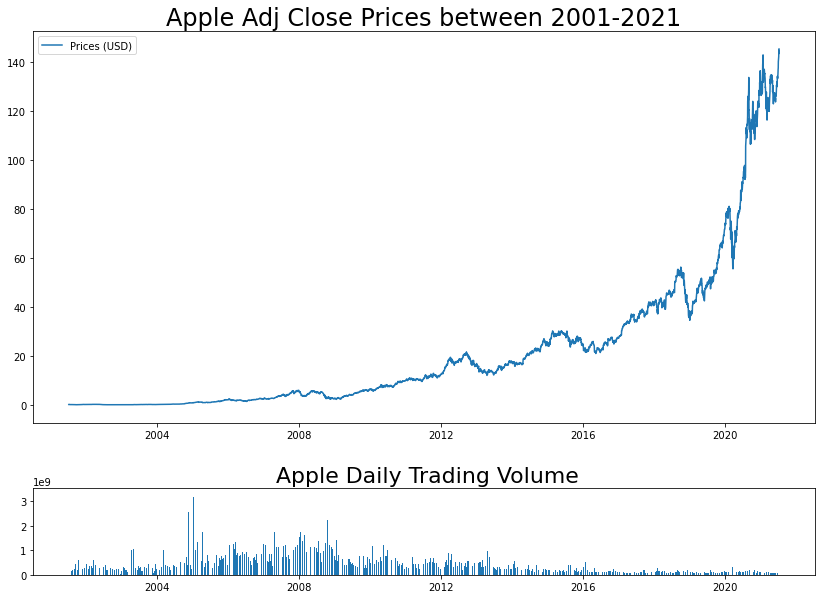

In [26]:
prices = apple['Adj Close']
volumes = apple['Volume']

# The top plot consisting of daily closing prices
top = plt.subplot2grid((4,4), (0,0), rowspan=3, colspan=4)
top.plot(prices.index, prices, label='Prices (USD)')
plt.title('Apple Adj Close Prices between 2001-2021', fontsize=24)
plt.legend(loc=2)

# The bottom plot consisting of daily trading volume
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(volumes.index, volumes)
plt.title(' Apple Daily Trading Volume', fontsize=22)


plt.gcf().set_size_inches(14, 10)
plt.subplots_adjust(hspace=0.75)

> ### 2. The 50 and 200 days EMA with price chart:

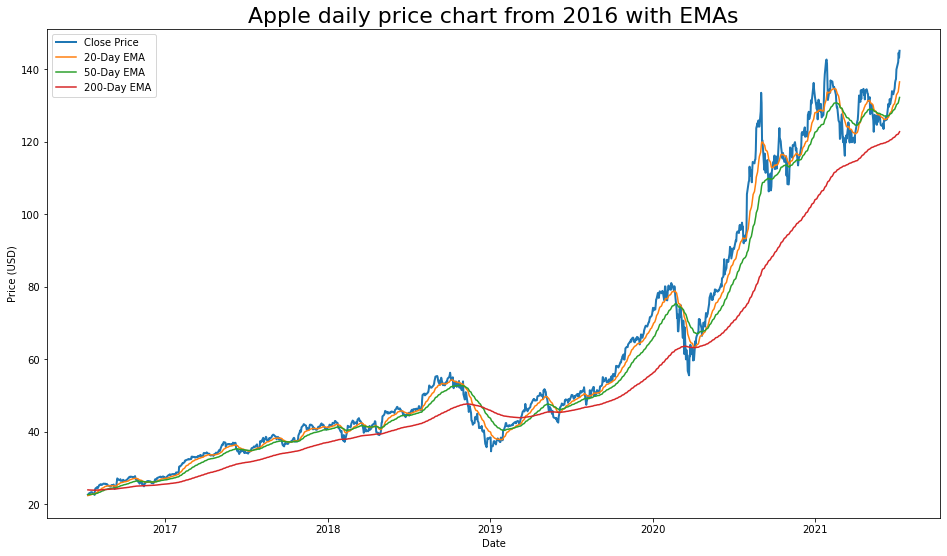

In [28]:
plt.figure(figsize = (16,9))

# To see the EMA lines properly, the chart is displayed only from this start date:
start_date = "2016-07-11"
price_from_2016 = apple['Adj Close'].loc[start_date:]

plt.plot(price_from_2016, label="Close Price", linewidth=2)

plt.plot(apple['ema20'].loc[start_date:], label="20-Day EMA")
plt.plot(apple['ema50'].loc[start_date:], label="50-Day EMA")
plt.plot(apple['ema200'].loc[start_date:], label="200-Day EMA")

plt.title('Apple daily price chart from 2016 with EMAs', fontsize=22)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()

# Define the date format
date_form = DateFormatter("%m-%d")

plt.show()

> ### 3. The 50 and 200 days RSI with price chart:

In [29]:
def plot_RSI(df, window):
    diff = df['Adj Close'].diff(periods=1).values
    xdate = [x.date() for x in df.index]
    RSI = []
    for i in range(window+1, len(xdate)):
        neg = 0
        pos = 0
        for value in diff[i-window:i+1]:
            if value > 0:
                pos += value # accumulate positive diff
            if value < 0:
                neg += value # accumulate negative diff
        pos_ave = pos/window # average price of positive diff
        neg_ave = np.abs(neg/window) # average absolute price of negative diff
        rsi = pos_ave/(pos_ave+neg_ave)*100
        RSI.append(rsi)

    # draw RSI figure
    plt.plot(xdate[window+1:], RSI, label = "RSI {}".format(window), lw=2.5, alpha=0.6)
    plt.xlim(xdate[window+1], xdate[-1])
    plt.ylim(0,100)
    plt.legend()

def RSI(df, windows):
    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(15, 10))
    
    # plot the original closing line
    plt.subplot(211)
    plt.plot(xdate, df['Adj Close'], label="close")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    
    # plot RSI
    plt.subplot(212)
    plt.grid()
    plt.title("RSI")
    for window in windows:
        plot_RSI(df, window)

    # fill area above 70 and below 30
    plt.fill_between(xdate, np.ones(len(xdate))*30, color="blue", alpha=0.1)
    plt.fill_between(xdate, np.ones(len(xdate))*70, np.ones(len(xdate))*100, color="red", alpha=0.1)
    
    # draw dotted lines at 70 and 30
    plt.plot(xdate, np.ones(len(xdate))*30, color="blue", linestyle="dotted")
    plt.plot(xdate, np.ones(len(xdate))*70, color="red", linestyle="dotted")
    plt.show()

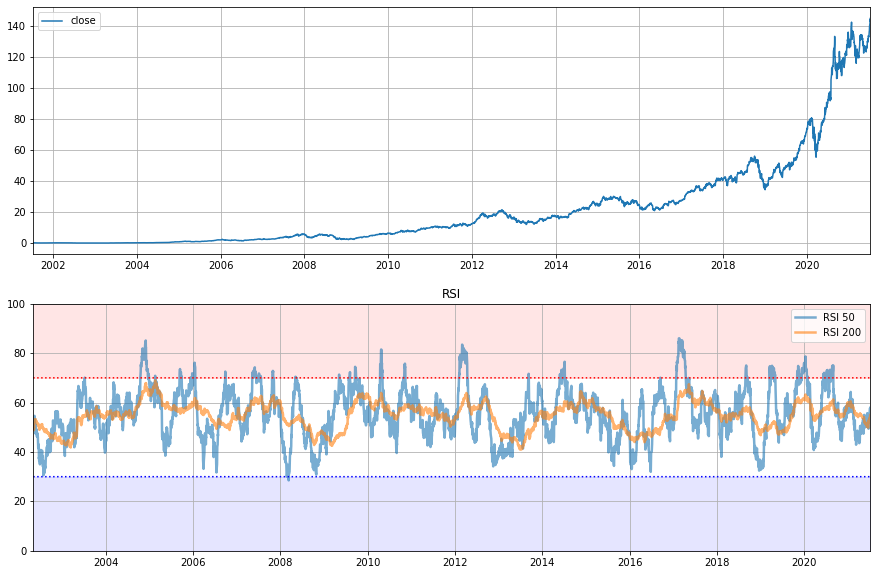

In [30]:
RSI(apple, [50, 200])

> ## 4. Price with Bollinger Bands

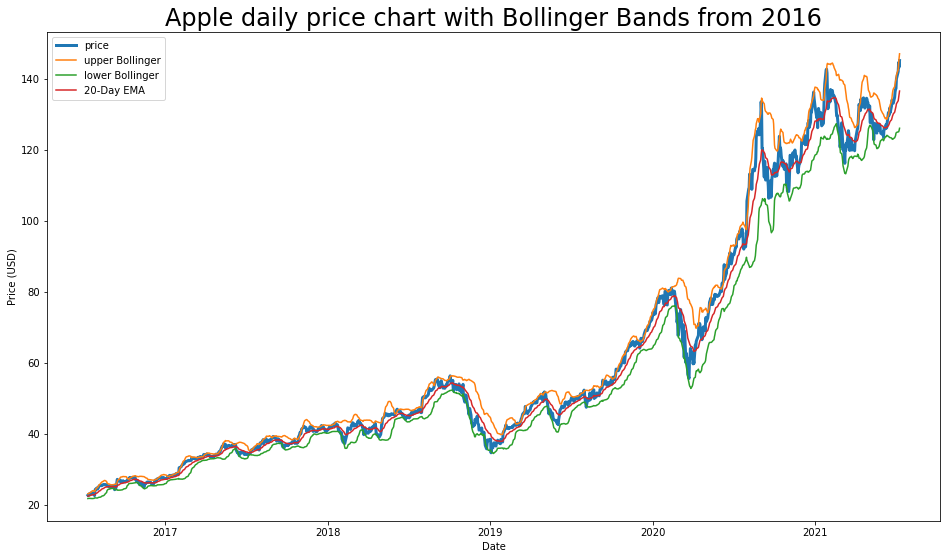

In [31]:
plt.figure(figsize = (16,9))

# Set start date
start_date = "2016-07-11"


plt.plot(apple['Adj Close'].loc[start_date:], label='price', linewidth=3)
plt.plot(apple['upper_bollinger'].loc[start_date:], label='upper Bollinger')
plt.plot(apple['lower_bollinger'].loc[start_date:], label='lower Bollinger')
plt.plot(apple['ema20'].loc[start_date:], label="20-Day EMA")

plt.title('Apple daily price chart with Bollinger Bands from 2016', fontsize=24)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()

plt.show()

> ## 5. Daily log returns

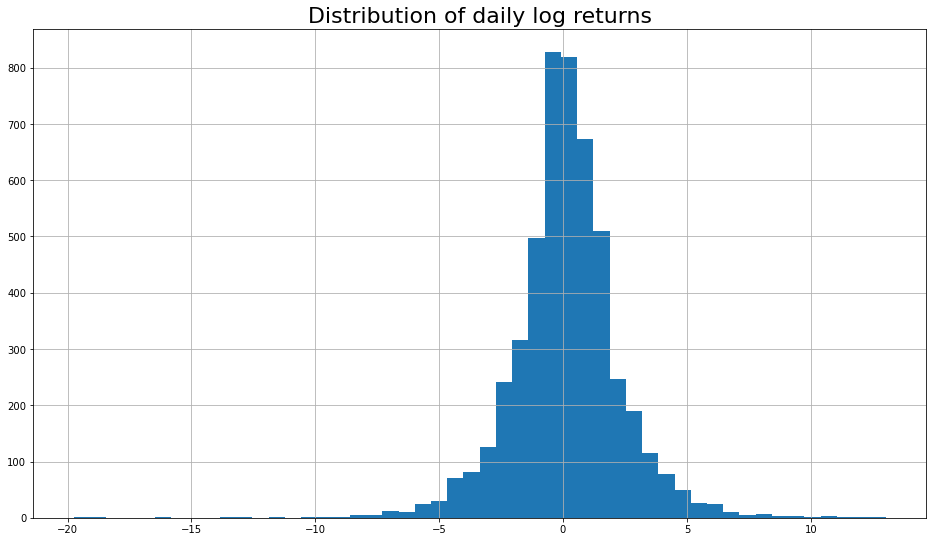

count    5030.000000
mean        0.120049
std         2.230981
min       -19.746986
25%        -0.929693
50%         0.100283
75%         1.244852
max        13.019405
Name: Daily log returns(%), dtype: float64


In [32]:
plt.figure(figsize=(16,9))
apple['Daily log returns(%)'].hist(bins=50)
plt.title('Distribution of daily log returns', fontsize=22)

plt.show()


print(apple['Daily log returns(%)'].describe())

The distribution looks symmetrical and normally distributed around the mean of 0.12%, which is very close to 0. However, the distribution is not a perfect normal distribution, becuase the median (the 50% percentile) is 0.1, slightly lower than the mean, representing a very small positive skewness. The standard deviation is 2.23, the lowest daily log return was almost -20% and the maximum jump in a day was 13% in the last 20 years.

> ## 6. Plotting of daily normal returns

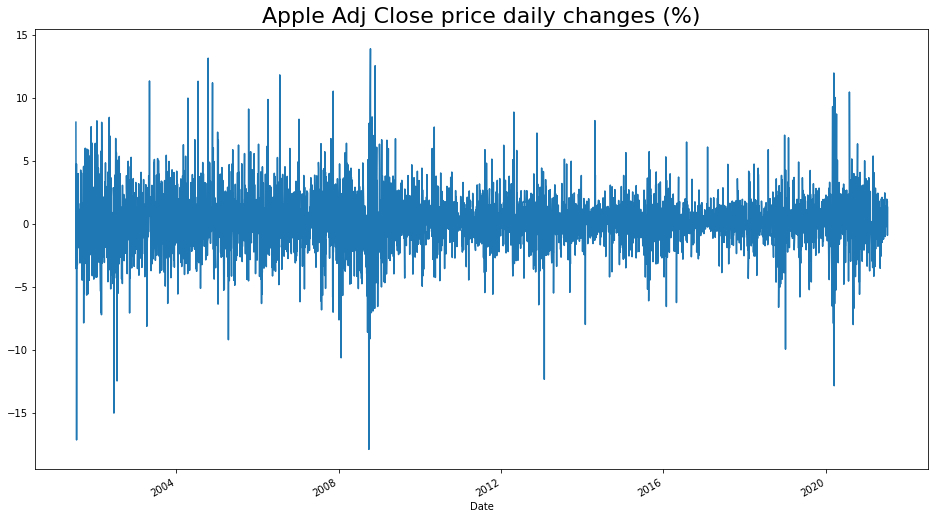

In [35]:
%matplotlib inline

daily_changes = (apple['Adj Close'].pct_change(periods=1))*100
plt.figure(figsize=(16,9))
plt.title('Apple Adj Close price daily changes (%)', fontsize=22)
daily_changes.plot();


plt.show()


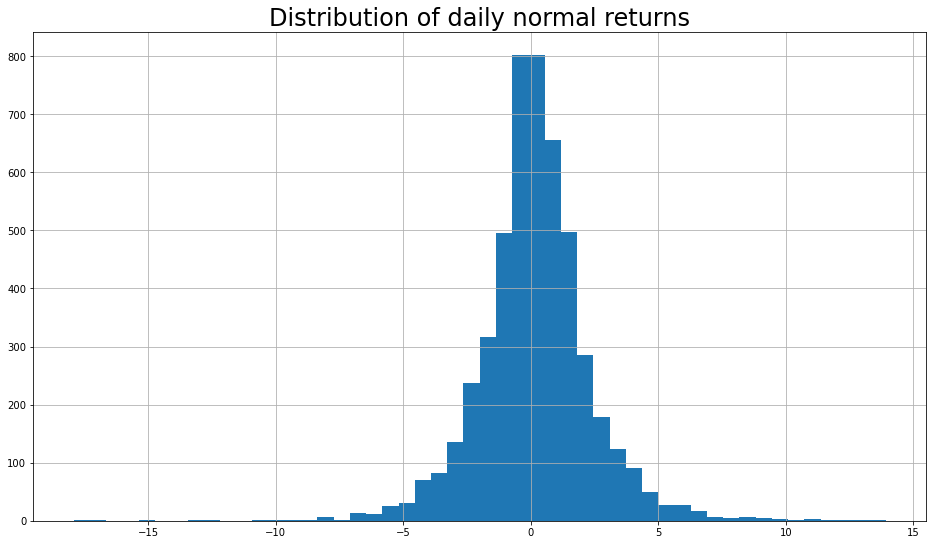

count    5030.000000
mean        0.144987
std         2.228964
min       -17.919512
25%        -0.925384
50%         0.100333
75%         1.252632
max        13.904939
Name: Adj Close, dtype: float64


In [36]:
plt.figure(figsize=(16,9))
daily_changes.hist(bins=50)
plt.title('Distribution of daily normal returns', fontsize=24)

plt.show()

print(daily_changes.describe())

The distribution of the daily normal returns looks symmetrical and normally distributed, just like log returns. However, the mean is around 0.145, the biggest price drop was around 18% happened around the big financial crisis in 2008. The max daily jump was almost 14%.

> ## 7. Plotting of cumulative return

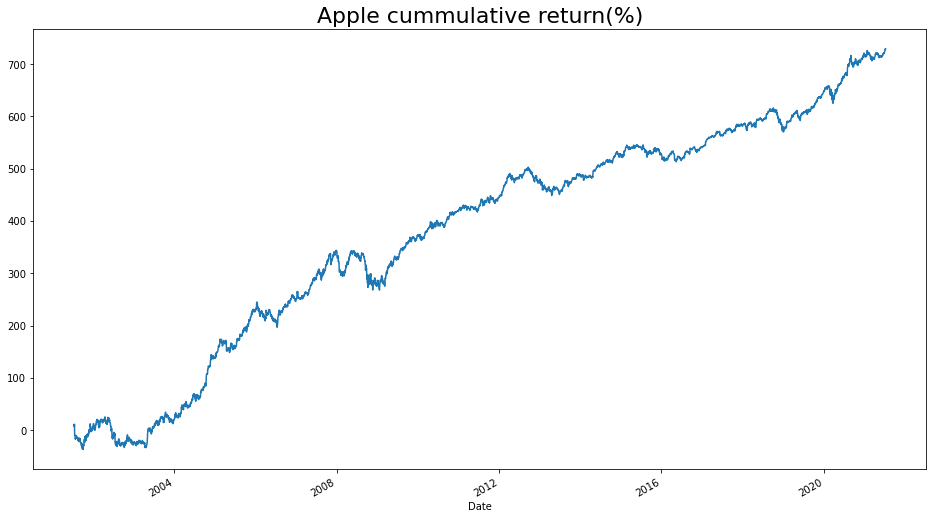

In [37]:
apple_cumsum = daily_changes.cumsum()
plt.figure(figsize=(16,9))
plt.title('Apple cummulative return(%)', fontsize=22)
apple_cumsum.plot();

Apple stocks provided an extraordinary 700% cummulative returns in the last 20 years on this bull market. 

> ## 8. Plotting Volatility

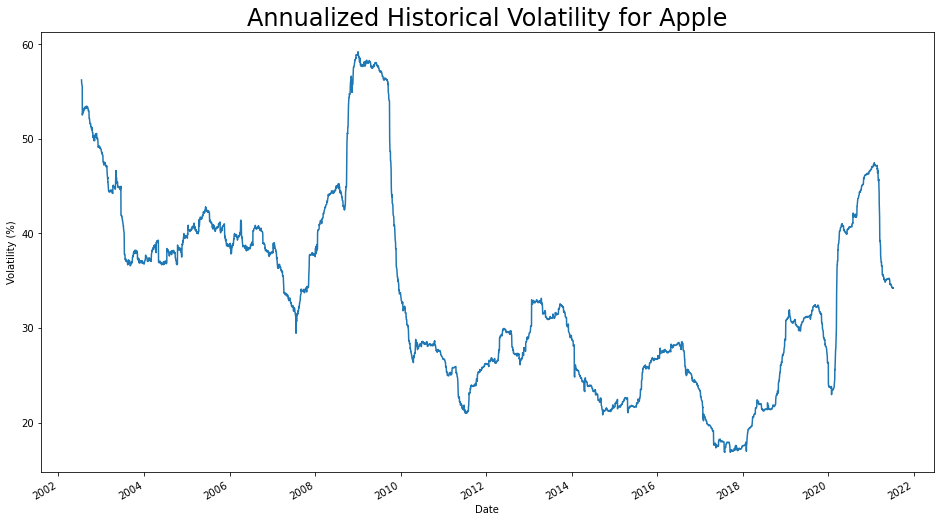

In [38]:
# For annualized volatility we need to use the yearly trading days 252:
trading_days = 252
volatility = log_returns.rolling(window=trading_days).std()*np.sqrt(trading_days)

# Plot the line chart:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility (%)')
ax1.set_title('Annualized Historical Volatility for Apple', fontsize=24)
plt.show()

> ## 9. Plotting Sharpe Ratio

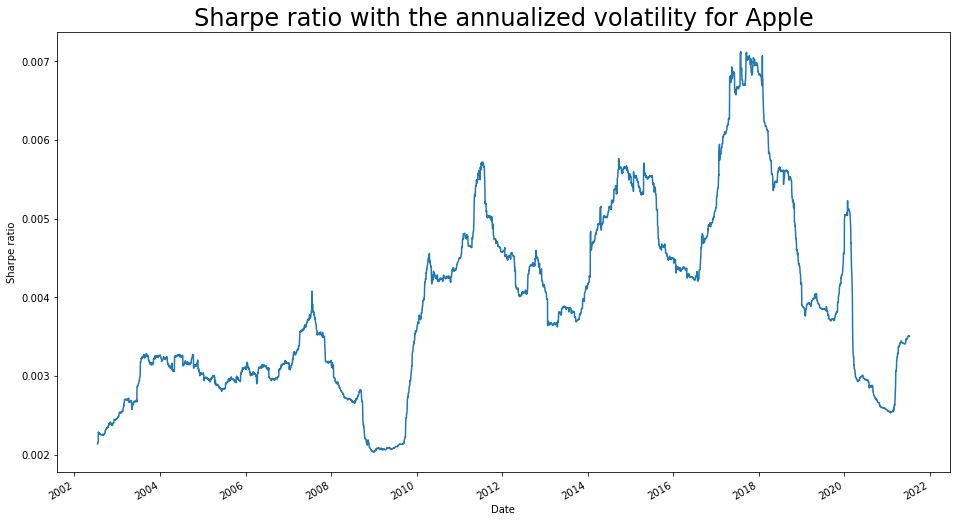

In [39]:
sharpe_ratio = log_returns.mean()/volatility

# Plot the line chart:
fig = plt.figure(figsize=(16, 9))
ax2 = fig.add_subplot(1, 1, 1)
sharpe_ratio.plot(ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sharpe ratio')
ax2.set_title('Sharpe ratio with the annualized volatility for Apple', fontsize=24)
plt.show()

# II.II. Descriptive Statistics

In [40]:
apple.describe()

,Adj Close,Volume,ema20,rsi20,ema50,rsi50,ema200,rsi200,20d_std,upper_bollinger,...,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,Daily log returns(%),7d_volatility,30d_volatility,252d_volatility,next_day_future_change,Prediction
count,5031.000000,5.031000e+03,5012.000000,5011.000000,4982.000000,4981.000000,4832.000000,4831.000000,5012.000000,5012.000000,...,5001.000000,4941.000000,5024.000000,5001.000000,5030.000000,5024.000000,5001.000000,4779.000000,5030.000000,5031.000000
mean,21.850776,4.344720e+08,21.674226,55.400669,21.413951,54.835709,20.215793,54.180375,0.683719,23.041665,...,0.068429,0.068611,0.010041,0.044681,0.120049,5.102780,11.152684,33.384278,0.028780,0.526138
std,29.442480,3.850962e+08,29.011616,11.224825,28.390237,7.459160,25.322096,3.863031,1.125747,30.979955,...,0.057074,0.036542,0.057605,0.123619,2.230981,2.973728,4.792658,10.012788,0.754634,0.499366
min,0.201463,3.934000e+07,0.211526,24.194219,0.217353,34.491583,0.236661,45.770368,0.003844,0.227873,...,-0.042963,0.003262,-0.304741,-0.491956,-19.746986,0.321278,2.775565,16.862780,-10.468438,0.000000
25%,2.207800,1.590452e+08,2.192800,47.462618,2.184487,49.847166,2.365708,51.432389,0.084266,2.360205,...,0.035796,0.046316,-0.022923,-0.030351,-0.929693,3.047568,7.666044,25.772411,-0.066439,0.000000
50%,11.030712,3.142496e+08,11.275616,55.189257,11.204643,54.887599,11.179024,54.557610,0.293175,12.190335,...,0.059154,0.059689,0.010793,0.045688,0.100283,4.451909,10.277480,31.649848,0.002303,1.000000
75%,27.787898,5.901798e+08,27.448417,63.471345,27.330092,59.720379,26.716998,56.787474,0.707139,29.015555,...,0.084161,0.080895,0.044013,0.120509,1.244852,6.417266,13.740707,40.196006,0.104416,1.000000
max,145.110001,3.372970e+09,136.530464,89.059955,132.238179,80.694075,122.777460,66.985015,8.892415,147.018006,...,0.617386,0.278206,0.310861,0.611322,13.019405,25.274156,37.317672,59.186923,10.002601,1.000000


In [41]:
apple.columns

Index(['Adj Close', 'Volume', 'ema20', 'rsi20', 'ema50', 'rsi50', 'ema200',
       'rsi200', '20d_std', 'upper_bollinger', 'lower_bollinger', 'MACD',
       'MACD_9EMA_signal', 'Volume 7d change', 'Volume 30d change',
       'Volume 90d change', '7d_price_change', '30d_price_change',
       'Daily log returns(%)', '7d_volatility', '30d_volatility',
       '252d_volatility', 'next_day_future_change', 'Prediction'],
      dtype='object')

In [42]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5031 entries, 2001-07-11 to 2021-07-09
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Adj Close               5031 non-null   float64
 1   Volume                  5031 non-null   int64  
 2   ema20                   5012 non-null   float64
 3   rsi20                   5011 non-null   float64
 4   ema50                   4982 non-null   float64
 5   rsi50                   4981 non-null   float64
 6   ema200                  4832 non-null   float64
 7   rsi200                  4831 non-null   float64
 8   20d_std                 5012 non-null   float64
 9   upper_bollinger         5012 non-null   float64
 10  lower_bollinger         5012 non-null   float64
 11  MACD                    5031 non-null   float64
 12  MACD_9EMA_signal        5031 non-null   float64
 13  Volume 7d change        5024 non-null   float64
 14  Volume 30d change     

In [43]:
apple.shape

(5031, 24)

Currently, the dataset has 5031 rows with 24 variables. 

In [44]:
apple.isna().sum()

Adj Close                   0
Volume                      0
ema20                      19
rsi20                      20
ema50                      49
rsi50                      50
ema200                    199
rsi200                    200
20d_std                    19
upper_bollinger            19
lower_bollinger            19
MACD                        0
MACD_9EMA_signal            0
Volume 7d change            7
Volume 30d change          30
Volume 90d change          90
7d_price_change             7
30d_price_change           30
Daily log returns(%)        1
7d_volatility               7
30d_volatility             30
252d_volatility           252
next_day_future_change      1
Prediction                  0
dtype: int64

The dataset has many null values at the moment due to the calculation methods of the indicators. We are going to deal with them later. 

## Correlations

It is important to check the correlation between the variables before building the machine learning models.

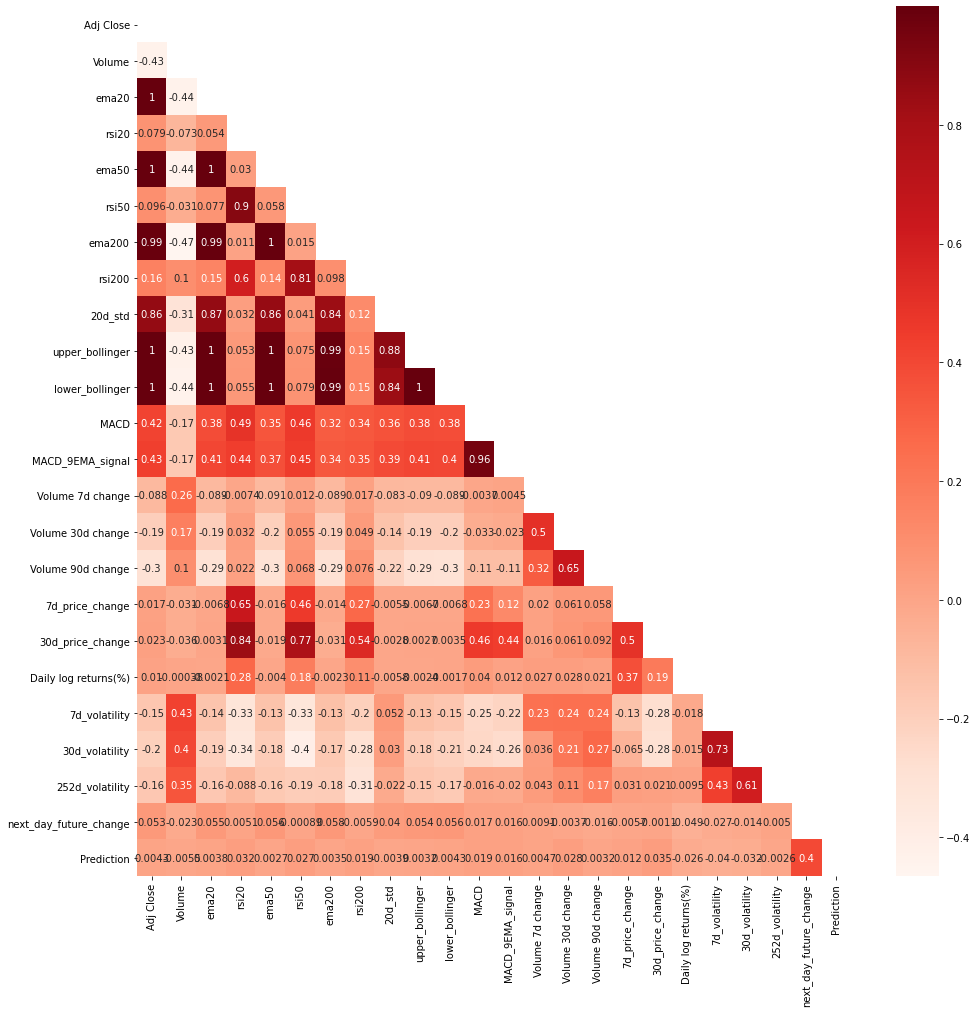

In [45]:
plt.figure(figsize=(16,16))
cor=apple.corr()

mask = np.triu(np.ones_like(cor, dtype=bool))
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds, mask=mask)

plt.show()

# <center> III. Data Cleaning </center>

However, we added many feature variables and created one target variable, explored the data through visualization and descriptive statistics, the dataset are not ready yet for machine learning tasks. It still needs some more preparation:

- NaN values has to be removed, because ML models can't accept them
- Drop non-stationary columns
- Remove highly correlated features


## III.I. Drop missing values

In [46]:
# We need to remove all rows that have an NaN value.
print('Before removing missing values we have {} rows and {} columns.'.format(apple.shape[0], apple.shape[1]))

# Any row that has a `NaN` value will be dropped.
apple = apple.dropna()

# Display how much we have left now.
print('After removing missing values we have {} rows and {} columns.'.format(apple.shape[0], apple.shape[1]))

Before removing missing values we have 5031 rows and 24 columns.
After removing missing values we have 4778 rows and 24 columns.


In [47]:
# Create new X and y without the missing values:
X = apple[feature_names].copy()
y = apple['Prediction'].copy()

## III.II. Stationarity check

Use the adfuller method to check the stationarity of the features and remove the non-stationary ones from the X dataset.

In [48]:
print('Before removing non-stationary features we have {} features.'.format(X.shape[1]))

from statsmodels.tsa.stattools import adfuller

def stationary(series):
    """Function to check if the series is stationary or not.
    """

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'


# Check for stationarity adn drop non-stationary features:
for col in X.columns:
    if stationary(apple[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)
        


print('After removing non-stationary features we have {} features.'.format(X.shape[1]))

Before removing non-stationary features we have 20 features.
ema20 is not stationary. Dropping it.
rsi20 is stationary.
ema50 is not stationary. Dropping it.
rsi50 is stationary.
ema200 is not stationary. Dropping it.
rsi200 is stationary.
upper_bollinger is not stationary. Dropping it.
lower_bollinger is not stationary. Dropping it.
20d_std is not stationary. Dropping it.
MACD is stationary.
MACD_9EMA_signal is stationary.
Volume 7d change is stationary.
Volume 30d change is stationary.
Volume 90d change is stationary.
7d_price_change is stationary.
30d_price_change is stationary.
7d_volatility is stationary.
30d_volatility is stationary.
252d_volatility is not stationary. Dropping it.
Adj Close is not stationary. Dropping it.
After removing non-stationary features we have 12 features.


## III.III. Drop highly correlated columns

In the next step we drop some highly correlated features with the help of the following function. We set 0.85 correlation coefficient as the threshold.

In [49]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.85))

MultiIndex([( 'MACD', 'MACD_9EMA_signal'),
            ('rsi20',            'rsi50')],
           )


We can see, that the correlation between `MACD` and `MACD_9EMA_signal` and between `rsi20` and `rsi50` is above threshold of 0.85. For this reason, we drop one from each pair, namely the `MACD_9EMA_signal` and the `rsi50` feature from X dataset. 

In [50]:
X = X.drop(columns=['MACD_9EMA_signal', 'rsi50'], axis=1)

print('After dropping some highly correlated features we have {} of them.'.format(X.shape[1]))

After dropping some highly correlated features we have 10 of them.


### Display the final features 

In [51]:
X.head()

,rsi20,rsi200,MACD,Volume 7d change,Volume 30d change,Volume 90d change,7d_price_change,30d_price_change,7d_volatility,30d_volatility
Date,,,,,,,,,,
2002-07-17,35.540417,46.984286,-0.014110,0.410925,0.237394,0.129768,-0.132149,-0.313872,16.314375,26.441888
2002-07-18,33.843193,46.706112,-0.016183,0.323307,0.226182,0.124059,-0.144895,-0.340228,16.452441,26.579641
2002-07-19,33.763573,46.693078,-0.017660,0.291329,0.217856,0.120968,-0.136259,-0.324910,16.556251,26.579630
2002-07-22,33.652575,46.675642,-0.018664,0.193096,0.176632,0.124616,-0.184698,-0.302803,14.322024,26.501425
2002-07-23,32.391109,46.479338,-0.019790,0.156126,0.192457,0.122902,-0.173617,-0.326349,14.220829,26.512850


### Check shape and missing values of

> ### X:

In [52]:
# Check the number of rows:
a = X.shape[0]
b = X.shape[1]
print("The final dataset containing only the predictor variables (called X) has {} rows and {} columns.".format(a,b))

# Check missing values:
x_missing = X.isna().sum().sum()
print("X has {} missing values.".format(x_missing))

The final dataset containing only the predictor variables (called X) has 4778 rows and 10 columns.
X has 0 missing values.


> ### y:

In [53]:
# Check the number of rows:
y_rows = y.shape[0]
print("The final dependent dataset (called Y) has {} rows.".format(y_rows))

# Check missing values:
y_missing = y.isna().sum()
print("y has {} missing values.".format(y_missing))

The final dependent dataset (called Y) has 4778 rows.
y has 0 missing values.


### Check identicalness of X and y:

Now check whether X and y are identical, meaning the Date values are the same in both table and the they have the same number of rows.

In [54]:
# Put both X and Y indexes to list first. Call them X_dates and Y_dates:
X_index = X.index
X_dates = list(X_index)

y_index = y.index
y_dates = list(y_index)

# Check if they are identical:

if X_dates==y_dates:
    print ("The lists are identical, meaning that the Date values are the same in both the X and Y tables.")
else:
    print("The lists are not identical,meaning that the Date values are not the same in the X and Y tables.")

The lists are identical, meaning that the Date values are the same in both the X and Y tables.


We are done with the necessary data cleaning and preparation steps, now we are ready to build the machine learning models.

# <center> IV. Build Machine Learning Models </center>

In this chapter, we are going to build machine learning models to predict Apple stock prices directions:
- 3 different Random Forest Classifier models
- 1 Logistic Regression model
- 1 Decision Tree Classifier model


Now let's start the whole building process with the necessary train-test split, which will be used in all models.

## Train-test split

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
# Splitting the dataset into 20% testing data and 80% training data:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X_train variable is (3822, 10).
The shape of the y_train variable is (3822,).

The shape of the X_test variable is (956, 10).
The shape of the y_test variable is (956,).



The train-test split was successful, because 3822 is exactly 80% of the number of rows in the original X and y dataset. A few observation after the train-test split:

1. The dimensions of the `train_data` show that `X_train` has 11 features and 3822 observations. The target variable for the train data (`y_train`) has one column and the same number of observations as `X_train`.<br><br>
1. The dimensions of the `test_data` show that `X_test` has 11 features and 956 observations. That is the 20% of 4778, the number of rows in X, rounded up to the closest integer. The target variable for the train data (`y_test`) has one column and the same number of observations as `X_test`.

### Visualise the Data

Plot one of the columns of the features to see how the data is split.

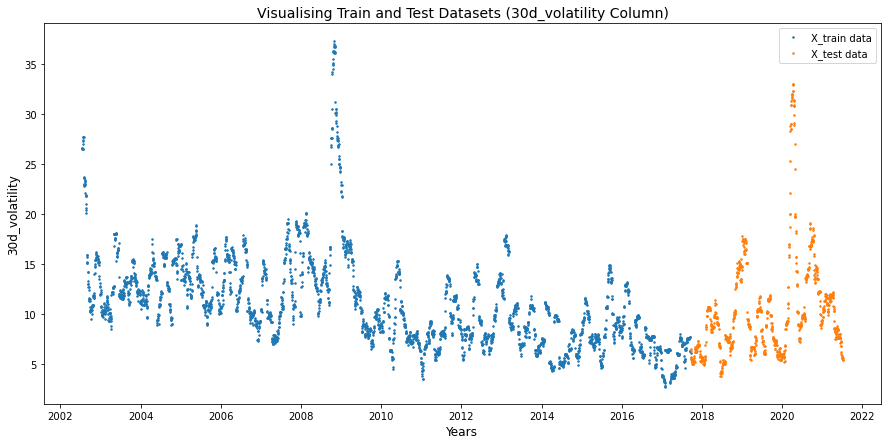

In [57]:
# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['30d_volatility'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['30d_volatility'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (30d_volatility Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('30d_volatility', fontsize=12)

# Display the plot
plt.legend()
plt.show()

We can see that the `train_data` (blue points) and the `test_data` (orange points) are **not** randomly shuffled. The model is trained on `train_data` (blue part) and then the performance is evaluated for the `test_data` (orange part). So, this way we eliminate the issue where we possibly were using future data to predict the past. Here, the model will be trained on data up to 2018 (blue part) and then it will be used to make predictions for the future.

# IV.I. Random Forest Classifier
-------------------------

We are going to build three Random Forest Classifier model in this section:
1. Base model
2. Second model with features > 0.1 importance score
3. Third model with GridSearch

Let's start with importing the necessary packages:

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
from lime import lime_tabular
from sklearn.ensemble import RandomForestRegressor
import lime
from lime import lime_tabular
from sklearn import metrics

from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.model_selection import RandomizedSearchCV

In [59]:
rf = RandomForestClassifier()

In [60]:
class Buy_or_Sell_Classifier_RF:
    '''
    Use RandomForestClassifier to classify buy or sell decisions.
    '''
    
    def __init__(self, model_name, param, features):
        '''
        Initialize and create model.
        
        Parameters:
        - model_name: name of the model
        - param: a dictionary of parameters for grid search
        - features: a list of features to be used in the model
        '''
        
        self.model_name = model_name
        self.model = GridSearchCV(estimator=RandomForestClassifier(), 
                                  param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.predict_proba = None
        self.explainer = None
        self.predict_fn_rf = lambda x: self.model.predict_proba(x).astype(float)
    
    def train_n_evaluate(self, X_train, y_train, X_test, y_test):
        '''
        Train and evaluate model.
        
        parameters:
        - X_train: training set
        - y_train: class label for training set
        - X_test: test set
        - y_test: class label for test set
        '''
        
        start_time = time.time()
        self.model.fit(X_train, y_train)                                # fit the model
        stop_time = time.time()
        self.y_predict = self.model.predict(X_test)                     # predictions for test set
        self.predict_proba = self.model.predict_proba(X_test)           # prediction' probability
        c_matrix = metrics.confusion_matrix(y_test, self.y_predict)     # confusion matrix
        
        # build a dictionary of performance metrics
        metrics_dict = {'model_name': self.model_name,
                        'true_neg': c_matrix[0][0],
                        'true_pos': c_matrix[1][1],
                        'false_neg': c_matrix[1][0],
                        'false_pos': c_matrix[0][1],
                        'accuracy': metrics.accuracy_score(y_test, self.y_predict),
                        'precision': metrics.precision_score(y_test, self.y_predict),
                        'recall': metrics.recall_score(y_test, self.y_predict),
                        'f1_score': metrics.f1_score(y_test, self.y_predict),
                        'training_time': round(stop_time - start_time)}
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
        # sort feature importance in descending order
        self.feature_imp = pd.Series(self.model.best_estimator_.feature_importances_, 
                                index=self.features).sort_values(ascending=False)
    
        # create explainer to help explain the prediction
        self.explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns,
                                              class_names=['Buy', 'Sell'], kernel_width=5)
    
    def explain_prediction(self, row, num_features=5):
        '''
        Show horizontal bar plot of prediction's probability along with the score for the top 5 features.
        
        Parameters:
        - row: row's number in the test set
        - num_features: the number of top features to show along with its' score
        '''
        
        # show prediction and explanation, show the top 5 features
        exp = self.explainer.explain_instance(row, self.predict_fn_rf, num_features=num_features)
        exp.show_in_notebook(show_all=False)
        return exp
    
    def plot_feature_importance(self, figsize=(6, 6)):
        '''
        Create a bar plot of feature importance
        
        Parameter:
        - figsize: size of the figure
        '''
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # create a bar plot of feature importance
        sns.barplot(x=self.feature_imp, y=self.feature_imp.index)

        # add labels to graph
        plt.xlabel('Score')
        plt.ylabel('Features')
        plt.title('Feature Importance')
        plt.show()

In [61]:
# parameters for base model and reduced features model in Random Forest:
param = {'bootstrap': [True], 'n_estimators': [100]}

After these necessary steps let's start to build the three Random Forest models.

## 1. RF-Base model

In [63]:
base_model = Buy_or_Sell_Classifier_RF('base_model', param, list(X_train.columns))
base_model.train_n_evaluate(X_train, y_train, X_test, y_test)
base_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,base_model,248,236,280,192,0.506276,0.551402,0.457364,0.5,5


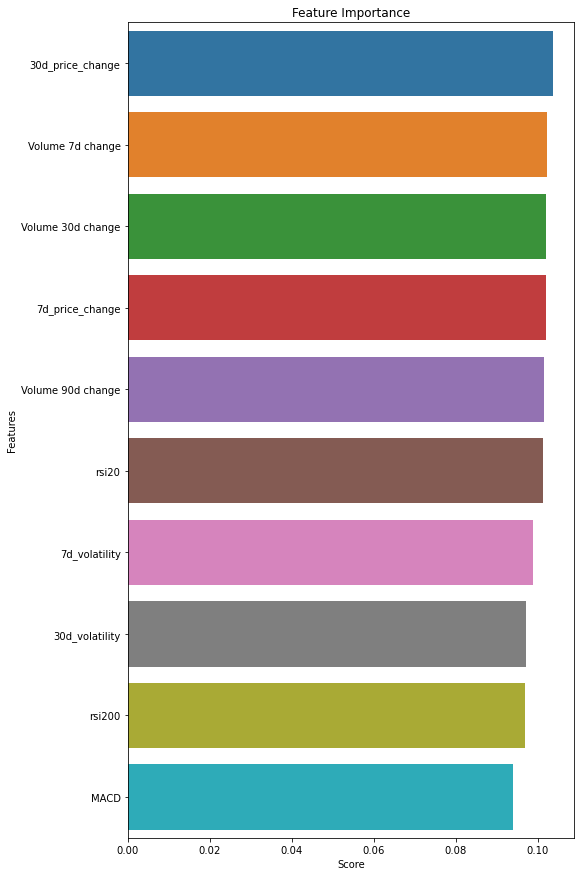

In [64]:
import seaborn as sns
base_model.plot_feature_importance((8, 15))

In this model, all the features were used with roughly the same importance score. The next model select only features with importance score greater than 0.1.

## 2. RF-Model 2 with feature importance > 0.1

In [65]:
# select features with important score > 0.1
features_m2 = list(base_model.feature_imp[base_model.feature_imp > 0.1].index)

model2 = Buy_or_Sell_Classifier_RF('feature_reduction', param, features_m2)
model2.train_n_evaluate(X_train[features_m2], y_train, X_test[features_m2], y_test)
model2.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,feature_reduction,180,319,197,260,0.521967,0.55095,0.618217,0.582648,2


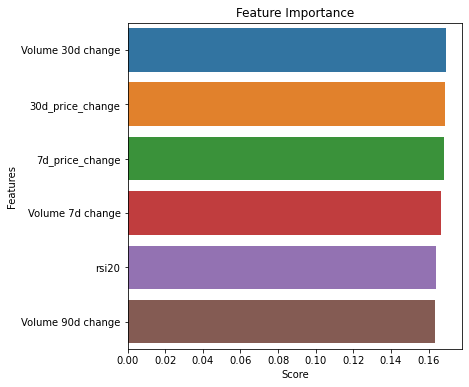

In [66]:
model2.plot_feature_importance()

## 3. RF-Model 3 with optimization

In [67]:
param_grid = {'bootstrap': [True],
              'max_depth': [80, 90, 100,110],
              'max_features': ['sqrt'],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300,1000]}

model3 = Buy_or_Sell_Classifier_RF('optimized', param_grid, features_m2)
model3.train_n_evaluate(X_train[features_m2], y_train, X_test[features_m2], y_test)
model3.metrics

Fitting 3 folds for each of 144 candidates, totalling 432 fits


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,optimized,152,324,192,288,0.497908,0.529412,0.627907,0.574468,474


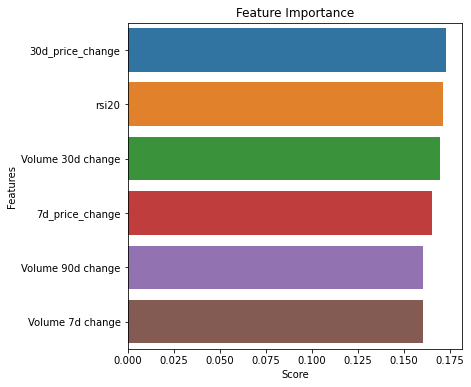

In [68]:
model3.plot_feature_importance()

### Comparison of RF models

> ### ROC Curve

ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR). Any increase in TPR occurs at the cost of an increase in FPR. The area under the ROC curve is a measure of the accuracy of the model.

- True Positive means that buy decisions are correctly predicted as buy decisions
- True negative means that sell decisions are correctly predicted as sell decisions
- False positive means that actual sell decisions are incorrectly predicted as buy decisions
- False negative means that actual buy decisions are incorrectly predicted as sell decisions

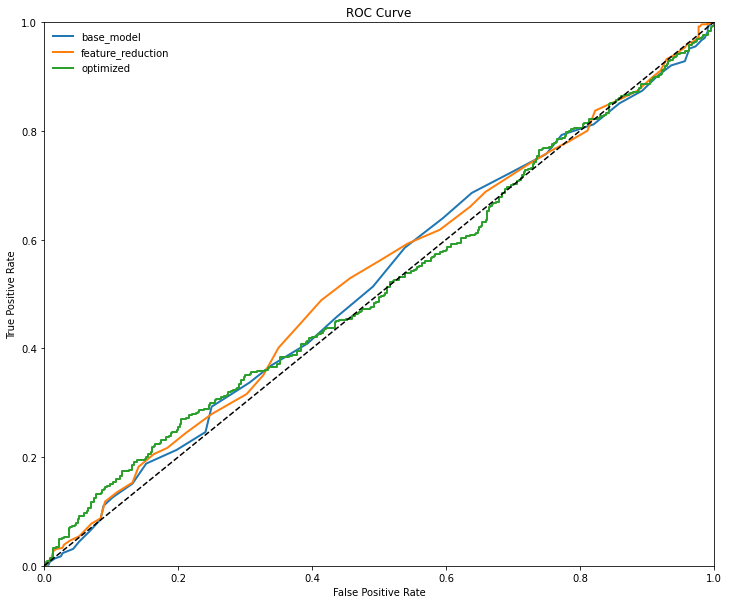

In [69]:
# plot roc curve for all RF models
fig, ax = plt.subplots(figsize=(12, 10))
labels = ['base_model', 'feature_reduction', 'optimized']

# iterate through all the models and plot roc curve for each model
for i, model in enumerate([base_model, model2, model3]):
    fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba[:,1])
    plt.plot(fpr, tpr, linewidth=2, label=labels[i])

plt.legend(loc='best', frameon=False)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

- The ROC curves appear to be a bit overlapped, but it looks like that RF-Model 2 with feature reduction performs slightly better than the other two models. 
- However, all the ROC curves are close to the black dotted line, which means that the models perform just slightly better than random guesses.

Let's check the metrics to get a better insight.

> ### Performance metrics

Comparing the three models based on the following metrics:



* Accuracy = (True Positives + True Negatives) / (Positive + Negative)
* Precision =  True Positive / (True Positive + False Positive)
* Sensitivity (Recall) = True Positive / TP+FN
* F1 score (harmonic mean of precision and sensitivity) = (2 \* precision \*sensitivity) / (precision + sensitivity)

In [70]:
# a dataframe that contains performance metrics for all RF model:
metrics_all_rf = pd.concat([base_model.metrics, model2.metrics, model3.metrics])

metrics_all_rf

,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,base_model,248,236,280,192,0.506276,0.551402,0.457364,0.500000,5
0,feature_reduction,180,319,197,260,0.521967,0.550950,0.618217,0.582648,2
0,optimized,152,324,192,288,0.497908,0.529412,0.627907,0.574468,474


* The RF-model 2 with feature reduction has the highest accuracy, precision rate and F1-score.
* RF-Model 3 with feature reduction has the highest true positive and lowest false negative rate. However it has the lowest accuracy and precision and took the longest to train by far.


# IV.II. Logistic Regression 
-------------------------

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [72]:
class Buy_or_Sell_Classifier_LR:
    '''
    Use Logistic Regression to classify buy or sell decisions.
    '''
    
    def __init__(self, model_name, param, features):
        '''
        Initialize and create model.
        
        Parameters:
        - model_name: name of the model
        - param: a dictionary of parameters for grid search
        - features: a list of features to be used in the model
        '''
        
        self.model_name = model_name
        self.model = GridSearchCV(estimator=LogisticRegression(), 
                                  param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.predict_proba = None
        self.explainer = None
        self.predict_fn_rf = lambda x: self.model.predict_proba(x).astype(float)
    
    def train_n_evaluate(self, X_train, y_train, X_test, y_test):
        '''
        Train and evaluate model.
        
        parameters:
        - X_train: training set
        - y_train: class label for training set
        - X_test: test set
        - y_test: class label for test set
        '''
        
        start_time = time.time()
        self.model.fit(X_train, y_train)                                # fit the model
        stop_time = time.time()
        self.y_predict = self.model.predict(X_test)                     # predictions for test set
        self.predict_proba = self.model.predict_proba(X_test)           # prediction' probability
        c_matrix = metrics.confusion_matrix(y_test, self.y_predict)     # confusion matrix
        
        # build a dictionary of performance metrics
        metrics_dict = {'model_name': self.model_name,
                        'true_neg': c_matrix[0][0],
                        'true_pos': c_matrix[1][1],
                        'false_neg': c_matrix[1][0],
                        'false_pos': c_matrix[0][1],
                        'accuracy': metrics.accuracy_score(y_test, self.y_predict),
                        'precision': metrics.precision_score(y_test, self.y_predict),
                        'recall': metrics.recall_score(y_test, self.y_predict),
                        'f1_score': metrics.f1_score(y_test, self.y_predict),
                        'training_time': round(stop_time - start_time)}
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
    
    
    

In [73]:
param_grid = {'solver':['liblinear']}

log_reg_model = Buy_or_Sell_Classifier_LR('logistic_regression_model', param_grid, list(X_train.columns))
log_reg_model.train_n_evaluate(X_train, y_train, X_test, y_test)
log_reg_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,logistic_regression_model,152,339,177,288,0.513598,0.54067,0.656977,0.593176,3


Same in classification report and confusion matrix:

In [74]:
# Create Logistic Regression object 
log_reg = LogisticRegression(solver='liblinear')

# Train Logistic Regression
log_reg = log_reg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_lr = log_reg.predict(X_test)

In [75]:
# Create classificiation report:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.46      0.35      0.40       440
           1       0.54      0.66      0.59       516

    accuracy                           0.51       956
   macro avg       0.50      0.50      0.49       956
weighted avg       0.50      0.51      0.50       956



The left-most column with values 0 and 1 represents the positions as follows:
1. `0` means short position, because the price is predicted to fall
1. `1` means a long position, because the price is predicted to rise

Result of the classification report:
- Based on the classification report, the logistic regression model's precision is 0.45 at the short labels and 0.54 at the long labels. With other words, it shows the accuracy of positive predictions.
- The F1 score shows, that 58% os positive predictions were correct at buy labels, and only 40% at sell labels. 
- The model's accuracy is 0.51, representing the overall performance of the algorithms. This is just slightly better than random guess. 
- There were 440 occurences of short signal and 516 occurences of buy signal.

### Confusion matrix

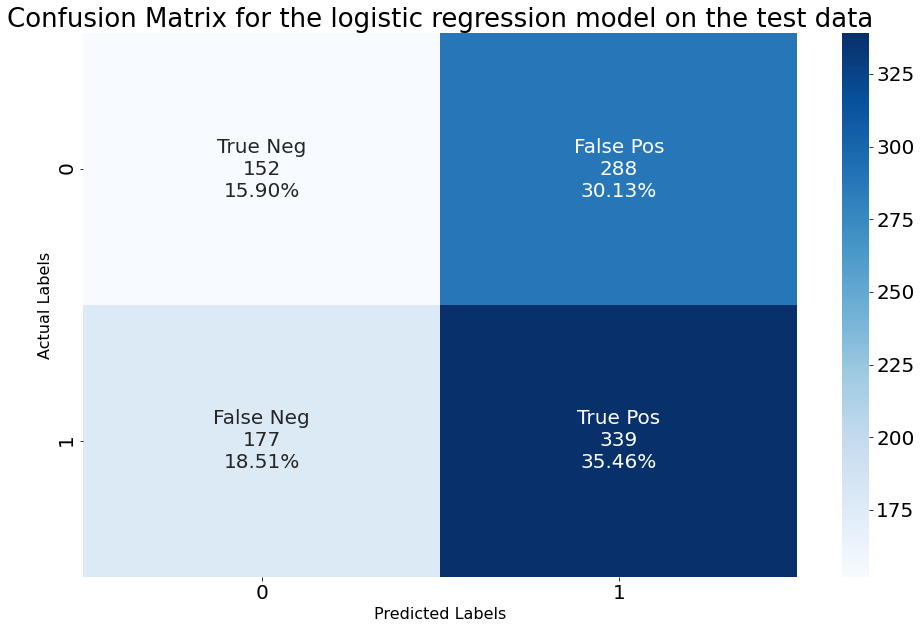

In [76]:
cf_matrix = confusion_matrix(y_test, y_pred_lr)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (16,10))
akws = {"ha": 'center',"va": 'top', "size":30}

plt.rcParams.update({'font.size': 20})

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=16)
plt.title('Confusion Matrix for the logistic regression model on the test data', size=26)
plt.show()


The confusion matrix is self-explanatory, showing the proportion of the TP, TN, FP, FN predictions to the actual labels, the same numbers as the dataframe above: 
1. True Positive: 339 correct predictions for taking a long position (represented by 1).
2. False Positive: 288 incorrect predictions for taking a long position based on model prediction when the actual action should have been short position.
3. True Negative: 152 correct predictions for taking short position.
4. False Negative: 177 incorrect predictions for taking short position based on model prediction when the actual action should have been long position.

# IV.III. Decision Tree Classifier
-------------------------

In [81]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
class Buy_or_Sell_Classifier_DT:
    '''
    Use Decision Tree to classify buy or sell decisions.
    '''
    
    def __init__(self, model_name, param, features):
        '''
        Initialize and create model.
        
        Parameters:
        - model_name: name of the model
        - param: a dictionary of parameters for grid search
        - features: a list of features to be used in the model
        '''
        
        self.model_name = model_name
        self.model = GridSearchCV(estimator=DecisionTreeClassifier(), 
                                  param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.predict_proba = None
        self.explainer = None
        self.predict_fn_rf = lambda x: self.model.predict_proba(x).astype(float)
    
    def train_n_evaluate(self, X_train, y_train, X_test, y_test):
        '''
        Train and evaluate model.
        
        parameters:
        - X_train: training set
        - y_train: class label for training set
        - X_test: test set
        - y_test: class label for test set
        '''
        
        start_time = time.time()
        self.model.fit(X_train, y_train)                                # fit the model
        stop_time = time.time()
        self.y_predict = self.model.predict(X_test)                     # predictions for test set
        self.predict_proba = self.model.predict_proba(X_test)           # prediction' probability
        c_matrix = metrics.confusion_matrix(y_test, self.y_predict)     # confusion matrix
        
        # build a dictionary of performance metrics
        metrics_dict = {'model_name': self.model_name,
                        'true_neg': c_matrix[0][0],
                        'true_pos': c_matrix[1][1],
                        'false_neg': c_matrix[1][0],
                        'false_pos': c_matrix[0][1],
                        'accuracy': metrics.accuracy_score(y_test, self.y_predict),
                        'precision': metrics.precision_score(y_test, self.y_predict),
                        'recall': metrics.recall_score(y_test, self.y_predict),
                        'f1_score': metrics.f1_score(y_test, self.y_predict),
                        'training_time': round(stop_time - start_time)}
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
    
    
    

In [83]:
param_grid = {}

dec_tree_model = Buy_or_Sell_Classifier_DT('Decision_Tree_model', param_grid, list(X_train.columns))
dec_tree_model.train_n_evaluate(X_train, y_train, X_test, y_test)
dec_tree_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,Decision_Tree_model,193,279,237,247,0.493724,0.530418,0.540698,0.535509,2


The Decision Tree Classifier produced the following results:
1. True Positive: 279 correct predictions for taking a long position (represented by 1).
2. False Positive: 247 incorrect predictions for taking a long position based on model prediction when the actual action should have been short position.
3. True Negative: 193 correct predictions for taking short position.
4. False Negative: 237 incorrect predictions for taking short position based on model prediction when the actual action should have been long position.

- The model's accuracy is 49.4%, representing the overall performance of the algorithms. This is slightly worse than random guess. 
- The precision is 53%, showing the percentage of correctly predicted positive observations to the total predicted positive observations. 

# Comparison of all models

In [84]:
# a dataframe that contains performance metrics for all model
metrics_all = pd.concat([base_model.metrics, model2.metrics, model3.metrics, log_reg_model.metrics, dec_tree_model.metrics])

metrics_all

,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,base_model,248,236,280,192,0.506276,0.551402,0.457364,0.500000,5
0,feature_reduction,180,319,197,260,0.521967,0.550950,0.618217,0.582648,2
0,optimized,152,324,192,288,0.497908,0.529412,0.627907,0.574468,474
0,logistic_regression_model,152,339,177,288,0.513598,0.540670,0.656977,0.593176,3
0,Decision_Tree_model,193,279,237,247,0.493724,0.530418,0.540698,0.535509,2


In [85]:
# Sort the dataframe by F1-score:

metrics_all = metrics_all.sort_values(by=['f1_score'], ascending=False)

metrics_all

,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,logistic_regression_model,152,339,177,288,0.513598,0.540670,0.656977,0.593176,3
0,feature_reduction,180,319,197,260,0.521967,0.550950,0.618217,0.582648,2
0,optimized,152,324,192,288,0.497908,0.529412,0.627907,0.574468,474
0,Decision_Tree_model,193,279,237,247,0.493724,0.530418,0.540698,0.535509,2
0,base_model,248,236,280,192,0.506276,0.551402,0.457364,0.500000,5


Based on F1-score, the logistic regression model is the best model, which provided the lowest false negative and the highest true positive cases. 

> ### ROC Curve

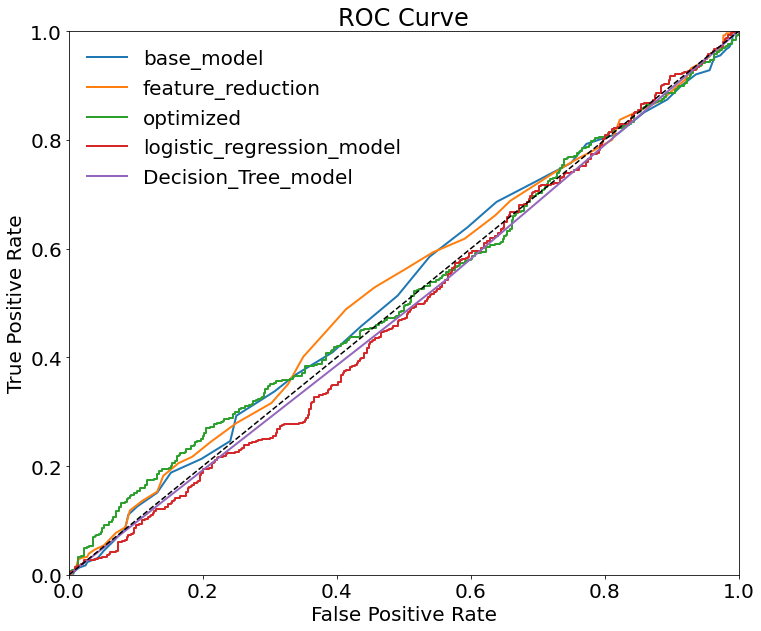

In [86]:
# plot roc curve for all RF models
fig, ax = plt.subplots(figsize=(12, 10))
labels = ['base_model', 'feature_reduction', 'optimized', 'logistic_regression_model', 'Decision_Tree_model']

# iterate through all the models and plot roc curve for each model
for i, model in enumerate([base_model, model2, model3, log_reg_model, dec_tree_model]):
    fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba[:,1])
    plt.plot(fpr, tpr, linewidth=2, label=labels[i])

plt.legend(loc='best', frameon=False)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

All the ROC curves are close to the dotted line which represents random guesses. 

# <center> V. Test the models </center>

# V.I. Prepare test dataframe

In this part, we are going to prepare the test dataframe that we will use for strategy testing purposes. It will be called `apple_strategy_test`.

But first we have to get the predicted buy (1) or sell (0) signals by the Machine Learning models. Put them to lists:

In [87]:
# Get the predicted values by the ML models to a list:
log_reg_predicted_values = log_reg_model.y_predict.tolist()
RF_base_predicted_values = base_model.y_predict.tolist()
RF_model2_predicted_values = model2.y_predict.tolist()
RF_model3_predicted_values = model3.y_predict.tolist()
DT_predicted_values = dec_tree_model.y_predict.tolist()

In [88]:
# Create a copy of y_test, call it y2:
y2 = pd.DataFrame(y_test.copy())

# Create new columns with the ML models' predicted values:
y2['Log_reg_predicted_values'] = log_reg_predicted_values
y2['RF_base_predicted_values'] = RF_base_predicted_values
y2['RF2_predicted_values'] = RF_model2_predicted_values
y2['RF3_predicted_values'] = RF_model3_predicted_values
y2['DT_predicted_values'] = DT_predicted_values

In [89]:
y2.head()

,Prediction,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values
Date,,,,,,
2017-09-20,0,1,0,0,0,0
2017-09-21,0,1,1,0,1,0
2017-09-22,0,1,1,1,1,1
2017-09-25,1,1,1,1,1,1
2017-09-26,1,1,1,1,1,0


In [90]:
# Drop the original Prediction column:
y2.drop(['Prediction'], axis=1, inplace=True)

y2.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values
Date,,,,,
2017-09-20,1,0,0,0,0
2017-09-21,1,1,0,1,0
2017-09-22,1,1,1,1,1
2017-09-25,1,1,1,1,1
2017-09-26,1,1,1,1,0


In [91]:
# Get the start date of y2 and keep it in a variable called y_start_date:
y_start_date = y2.first_valid_index()
print(y_start_date)

2017-09-20 00:00:00


In [92]:
# Create new temporary dataframe from the start date of y2, and with only the Adj Close column:
apple_two = apple.loc[y_start_date:]['Adj Close']

apple_two.head()

Date
2017-09-20    37.293449
2017-09-21    36.653049
2017-09-22    36.294628
2017-09-25    35.974426
2017-09-26    36.593315
Name: Adj Close, dtype: float64

In [93]:
# Create the test dataframe called apple_strategy_test. We are going to use this one for testing purposes. 
# Currently it contains the target variable (Prediction) and the Adj Close prices of Apple:
apple_strategy_test = pd.merge(y2, apple_two, on='Date')

apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Adj Close
Date,,,,,,
2017-09-20,1,0,0,0,0,37.293449
2017-09-21,1,1,0,1,0,36.653049
2017-09-22,1,1,1,1,1,36.294628
2017-09-25,1,1,1,1,1,35.974426
2017-09-26,1,1,1,1,0,36.593315


In [94]:
# Create new column containing the actual daily returns of Apple:
apple_strategy_test['apple_daily_return'] = apple_strategy_test['Adj Close'].pct_change()

apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Adj Close,apple_daily_return
Date,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN
2017-09-21,1,1,0,1,0,36.653049,-0.017172
2017-09-22,1,1,1,1,1,36.294628,-0.009779
2017-09-25,1,1,1,1,1,35.974426,-0.008822
2017-09-26,1,1,1,1,0,36.593315,0.017204


Now create a new column called `Actual` which contains the actual price changes for the specific day. 1 means up days, 0 means down or flat days:

In [95]:
# write a simple function first that define up or down days:
def up_or_down(x):
    if x > 0:
        return 1
    else:
        return 0


# Create the actual column, which shows the actual closing price change for that day. Classify price up days 1, down and flat days 0:
apple_strategy_test['Actual'] = apple_strategy_test['apple_daily_return'].map(up_or_down)

In [96]:
apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Adj Close,apple_daily_return,Actual
Date,,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN,0
2017-09-21,1,1,0,1,0,36.653049,-0.017172,0
2017-09-22,1,1,1,1,1,36.294628,-0.009779,0
2017-09-25,1,1,1,1,1,35.974426,-0.008822,0
2017-09-26,1,1,1,1,0,36.593315,0.017204,1


In [97]:
# Rename column:
apple_strategy_test.rename(columns = {'Adj Close': 'Apple Adj Close'}, inplace=True)

### Import S&P500 Data

In [98]:
# Source: https://stooq.com/q/d/?s=%5Espx&c=0&d1=20010501&d2=20210709

sp500 = pd.read_csv('spx_d.csv')

In [99]:
sp500.head()

,Date,Open,High,Low,Close,Volume
0,2001-05-01,1249.38,1266.47,1243.55,1266.44,656277778
1,2001-05-02,1270.59,1272.93,1257.70,1267.43,745666667
2,2001-05-03,1263.52,1267.43,1239.88,1248.58,632166667
3,2001-05-04,1243.77,1267.51,1232.00,1266.61,601166667
4,2001-05-07,1266.93,1270.11,1259.16,1263.51,527222222


In [100]:
# Set the Date column as datetime
sp500['Date']=pd.to_datetime(sp500['Date'])

In [101]:
# Set the Date column as the index of the dataframe
sp500.set_index('Date', inplace=True)

In [102]:
sp500.rename(columns = {'Close': 'SP500 Close'}, inplace=True)

### Join the two Dataframe

In [103]:
apple_strategy_test = apple_strategy_test.join(sp500['SP500 Close'])

apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Apple Adj Close,apple_daily_return,Actual,SP500 Close
Date,,,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN,0,2508.24
2017-09-21,1,1,0,1,0,36.653049,-0.017172,0,2500.60
2017-09-22,1,1,1,1,1,36.294628,-0.009779,0,2502.22
2017-09-25,1,1,1,1,1,35.974426,-0.008822,0,2496.66
2017-09-26,1,1,1,1,0,36.593315,0.017204,1,2496.84


In [104]:
apple_strategy_test.isna().sum()

Log_reg_predicted_values    0
RF_base_predicted_values    0
RF2_predicted_values        0
RF3_predicted_values        0
DT_predicted_values         0
Apple Adj Close             0
apple_daily_return          1
Actual                      0
SP500 Close                 0
dtype: int64

The dataframe contains only one missing value at the moment, the NaN in the first row of the `apple_daily_return` column. It does not have to bother us now. The test dataframe is ready for the testing purposes. Now start the strategy testing with 3 different strategies in the next section:

# V.II. Calculate performance on $10k investment

We calculate the performance of all ML model on a hypothetical \\$10k investment portfolio. We use the test dataset to evaluate how this investment would have grown over time and how it's performance would compare to the S&P 500 returns and also to the Apple cumulative returns. So we start with \\$10k on the first day of the test dataset, which is 2017-09-20, and see how our investment grows/decline.

Let's start with the first strategy, the Apple buy and hold strategy. This represents the scenario where we hypothetically bought Apple stocks for \\$10k and hold them until the end of the period (ignore transaction costs).

In [105]:
initial_investment = int(10000)

## 1. Cash with Apple buy and hold strategy

In [106]:
# Add column to list:
apple_daily_return = apple_strategy_test['apple_daily_return'] 

# Calculate cummulative daily returns:
apple_daily_cum_returns = (apple_daily_return + 1).cumprod()

# Create new column containing investment value of the strategy Apple buy and hold:
apple_strategy_test['Cash_Apple_buy_and_hold'] = initial_investment * apple_daily_cum_returns

In [107]:
apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Apple Adj Close,apple_daily_return,Actual,SP500 Close,Cash_Apple_buy_and_hold
Date,,,,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN,0,2508.24,NaN
2017-09-21,1,1,0,1,0,36.653049,-0.017172,0,2500.60,9828.280833
2017-09-22,1,1,1,1,1,36.294628,-0.009779,0,2502.22,9732.172533
2017-09-25,1,1,1,1,1,35.974426,-0.008822,0,2496.66,9646.312413
2017-09-26,1,1,1,1,0,36.593315,0.017204,1,2496.84,9812.263543


## 2. Cash with Logistic Regression model

Set conditions as the following logic:

- If the actual price movement was down (0) and the strategy predicted down (0), then the trade's actual return was positive and it raised the value of our initial investment
- If the actual price movement was down (0) and the strategy predicted up (1), then the trade's actual return was negative and it decreased the value our initial investment
- If the actual price movement was up (1) and the strategy predicted down (0), then the trade's actual return was negative and it decreased the value of our initial investment
- If the actual price movement was up (1) and the strategy predicted up (1), then the trade's actual return was positive and it raised the value of our initial investment

In [108]:
conditions = [
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['Log_reg_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['Log_reg_predicted_values'] == 1),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['Log_reg_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['Log_reg_predicted_values'] == 1)
]

choices = [-(apple_daily_return), apple_daily_return, -(apple_daily_return), apple_daily_return]

apple_strategy_test['Log_reg_model_daily_return'] = np.select(conditions, choices)

In [109]:
apple_strategy_test['Cash_Log_reg_model'] = ((apple_strategy_test['Log_reg_model_daily_return']+1).cumprod()) * initial_investment

In [110]:
apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Apple Adj Close,apple_daily_return,Actual,SP500 Close,Cash_Apple_buy_and_hold,Log_reg_model_daily_return,Cash_Log_reg_model
Date,,,,,,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN,0,2508.24,NaN,NaN,NaN
2017-09-21,1,1,0,1,0,36.653049,-0.017172,0,2500.60,9828.280833,-0.017172,9828.280833
2017-09-22,1,1,1,1,1,36.294628,-0.009779,0,2502.22,9732.172533,-0.009779,9732.172533
2017-09-25,1,1,1,1,1,35.974426,-0.008822,0,2496.66,9646.312413,-0.008822,9646.312413
2017-09-26,1,1,1,1,0,36.593315,0.017204,1,2496.84,9812.263543,0.017204,9812.263543


## 3. Cash with Random Forest base model

In [111]:
# Define conditions:
conditions = [
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF_base_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF_base_predicted_values'] == 1),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF_base_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF_base_predicted_values'] == 1)
]

choices = [-(apple_daily_return), apple_daily_return, -(apple_daily_return), apple_daily_return]

apple_strategy_test['RF_base_daily_return'] = np.select(conditions, choices)


apple_strategy_test['Cash_RF_base_model'] = ((apple_strategy_test['RF_base_daily_return']+1).cumprod()) * initial_investment

## 4. Cash with Random Forest2 model

In [112]:
# Define conditions:
conditions = [
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF2_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF2_predicted_values'] == 1),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF2_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF2_predicted_values'] == 1)
]

choices = [-(apple_daily_return), apple_daily_return, -(apple_daily_return), apple_daily_return]

apple_strategy_test['RF2_daily_return'] = np.select(conditions, choices)


apple_strategy_test['Cash_RF2_model'] = ((apple_strategy_test['RF2_daily_return']+1).cumprod()) * initial_investment

## 5. Cash with Random Forest3 model

In [113]:
# Define conditions:
conditions = [
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF3_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['RF3_predicted_values'] == 1),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF3_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['RF3_predicted_values'] == 1)
]

choices = [-(apple_daily_return), apple_daily_return, -(apple_daily_return), apple_daily_return]

apple_strategy_test['RF3_daily_return'] = np.select(conditions, choices)


apple_strategy_test['Cash_RF3_model'] = ((apple_strategy_test['RF3_daily_return']+1).cumprod()) * initial_investment

## 6. Cash with Decision Tree model

In [114]:
# Define conditions:
conditions = [
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['DT_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 0) & (apple_strategy_test['DT_predicted_values'] == 1),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['DT_predicted_values'] == 0),
    (apple_strategy_test['Actual'] == 1) & (apple_strategy_test['DT_predicted_values'] == 1)
]

choices = [-(apple_daily_return), apple_daily_return, -(apple_daily_return), apple_daily_return]

apple_strategy_test['DT_daily_return'] = np.select(conditions, choices)


apple_strategy_test['Cash_DT_model'] = ((apple_strategy_test['DT_daily_return']+1).cumprod()) * initial_investment

## 7. S&P 500 investment strategy

In [115]:
# Create SP500 daily returns:
SP500_daily_ret = apple_strategy_test['SP500 Close'].pct_change()

# Create SP500 daily cummulative returns:
sp500_daily_cum_returns = (SP500_daily_ret + 1).cumprod()

# Create new column containing investment value of the strategy SP500 buy and hold:
apple_strategy_test['Cash_SP500_buy_and_hold'] = initial_investment * sp500_daily_cum_returns

In [116]:
apple_strategy_test.head()

,Log_reg_predicted_values,RF_base_predicted_values,RF2_predicted_values,RF3_predicted_values,DT_predicted_values,Apple Adj Close,apple_daily_return,Actual,SP500 Close,Cash_Apple_buy_and_hold,...,Cash_Log_reg_model,RF_base_daily_return,Cash_RF_base_model,RF2_daily_return,Cash_RF2_model,RF3_daily_return,Cash_RF3_model,DT_daily_return,Cash_DT_model,Cash_SP500_buy_and_hold
Date,,,,,,,,,,,,,,,,,,,,,
2017-09-20,1,0,0,0,0,37.293449,NaN,0,2508.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-21,1,1,0,1,0,36.653049,-0.017172,0,2500.60,9828.280833,...,9828.280833,-0.017172,9828.280833,0.017172,10171.719167,-0.017172,9828.280833,0.017172,10171.719167,9969.540395
2017-09-22,1,1,1,1,1,36.294628,-0.009779,0,2502.22,9732.172533,...,9732.172533,-0.009779,9732.172533,-0.009779,10072.252469,-0.009779,9732.172533,-0.009779,10072.252469,9975.999107
2017-09-25,1,1,1,1,1,35.974426,-0.008822,0,2496.66,9646.312413,...,9646.312413,-0.008822,9646.312413,-0.008822,9983.392063,-0.008822,9646.312413,-0.008822,9983.392063,9953.832169
2017-09-26,1,1,1,1,0,36.593315,0.017204,1,2496.84,9812.263543,...,9812.263543,0.017204,9812.263543,0.017204,10155.142170,0.017204,9812.263543,-0.017204,9811.641956,9954.549804


### Plot graph

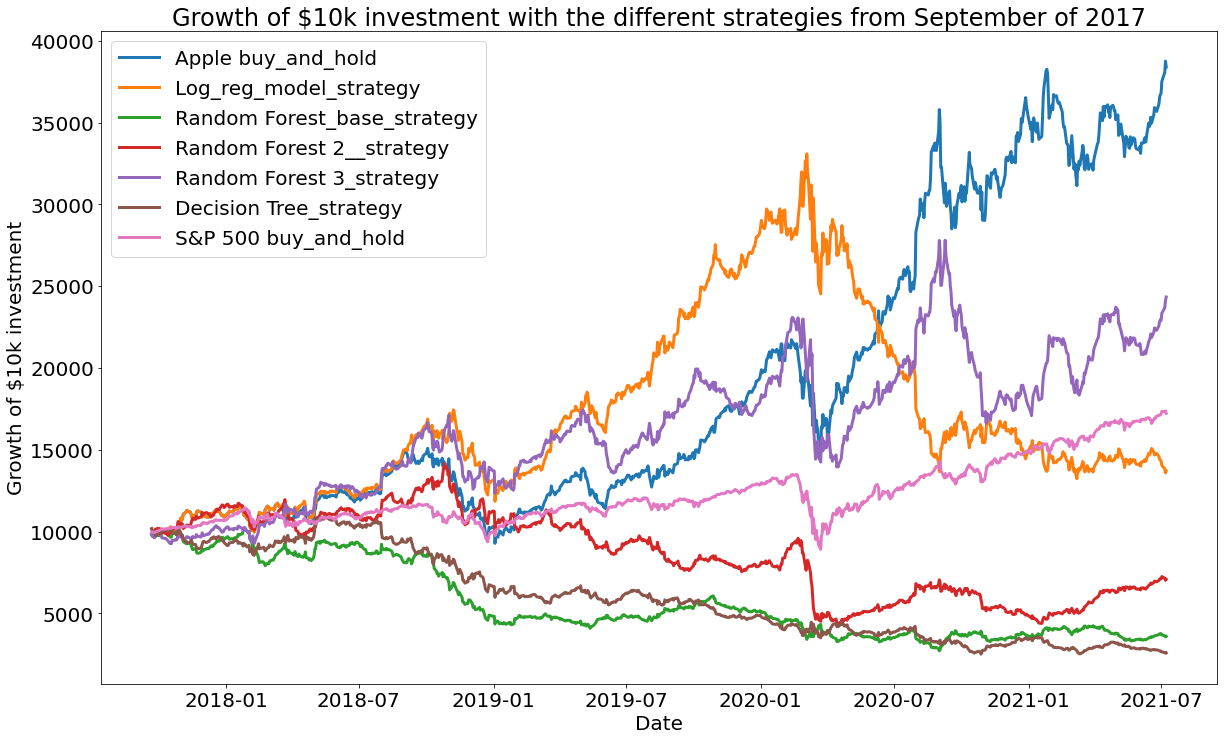

In [117]:
apple_buy_and_hold_cash = apple_strategy_test['Cash_Apple_buy_and_hold']
Log_reg_model_cash = apple_strategy_test['Cash_Log_reg_model']
RF_base_model_cash = apple_strategy_test['Cash_RF_base_model']
RF2_model_cash = apple_strategy_test['Cash_RF2_model']
RF3_model_cash = apple_strategy_test['Cash_RF3_model']
DT_model_cash = apple_strategy_test['Cash_DT_model']
sp500_cash = apple_strategy_test['Cash_SP500_buy_and_hold']

plt.figure(figsize=(20,12))


plt.plot(apple_buy_and_hold_cash, label='Apple buy_and_hold', linewidth=3)
plt.plot(Log_reg_model_cash, label='Log_reg_model_strategy', linewidth=3)
plt.plot(RF_base_model_cash, label='Random Forest_base_strategy', linewidth=3)
plt.plot(RF2_model_cash, label='Random Forest 2__strategy', linewidth=3)
plt.plot(RF3_model_cash, label='Random Forest 3_strategy', linewidth=3)
plt.plot(DT_model_cash, label='Decision Tree_strategy', linewidth=3)
plt.plot(sp500_cash, label='S&P 500 buy_and_hold', linewidth=3)

plt.title('Growth of $10k investment with the different strategies from September of 2017', fontsize=24)
plt.xlabel("Date")
plt.ylabel("Growth of $10k investment")
plt.legend()

plt.show()

A simple buy-and-hold strategy produced the best results by far, which almost fourfold the initial \\$10k investment. After that the tuned Random Forest model performed the best by the end of the test period. The logistic regression model produced very good results in the last 2 years, but after its returns fell drastically. By 2021, its performance is below the benchmark market returns, represented by the S&P 500 index. The strategy based on the Decision Tree and the Random Forest- base and 2 models did not work out, all of them produced roughly 40-50% loss.  